# 과제1 : 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고, 고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시하세요.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# csv
customers = pd.read_csv('./olist_customers_dataset.csv')      # 고객
orders = pd.read_csv('./olist_orders_dataset.csv')            # 주문
payments = pd.read_csv('./olist_order_payments_dataset.csv')  # 결제
reviews = pd.read_csv('./olist_order_reviews_dataset.csv')    # 리뷰

# 데이터 확인
customers.head(), customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


(                        customer_id                customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 
    customer_zip_code_prefix          customer_city customer_state  
 0                     14409                 franca             SP  
 1                      9790  sao bernardo do campo             SP  
 2                      1151              sao paulo             SP  
 3                      8775        mogi das cruzes             SP  
 4                     13056               campinas             SP  ,
 None)

In [ ]:
# 기본 통계값 계산
basic_stats = customers.describe(include='all')

# 고유 고객 수 계산
unique_customers_count = customers['customer_unique_id'].nunique()

# 고객별 주문 횟수 계산
customer_order_counts = customers['customer_unique_id'].value_counts()

# 결과 출력
basic_stats, unique_customers_count, customer_order_counts.head()

(                             customer_id                customer_unique_id  \
 count                              99441                             99441   
 unique                             99441                             96096   
 top     06b8999e2fba1a1fbc88172c00ba8bc7  8d50f5eadf50201ccdcedfb9e2ac8455   
 freq                                   1                                17   
 mean                                 NaN                               NaN   
 std                                  NaN                               NaN   
 min                                  NaN                               NaN   
 25%                                  NaN                               NaN   
 50%                                  NaN                               NaN   
 75%                                  NaN                               NaN   
 max                                  NaN                               NaN   
 
         customer_zip_code_prefix customer_city cu

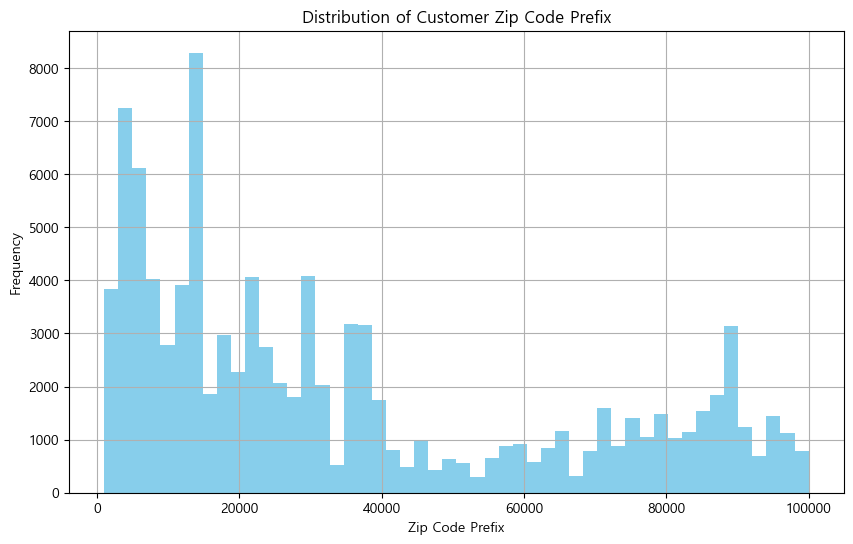

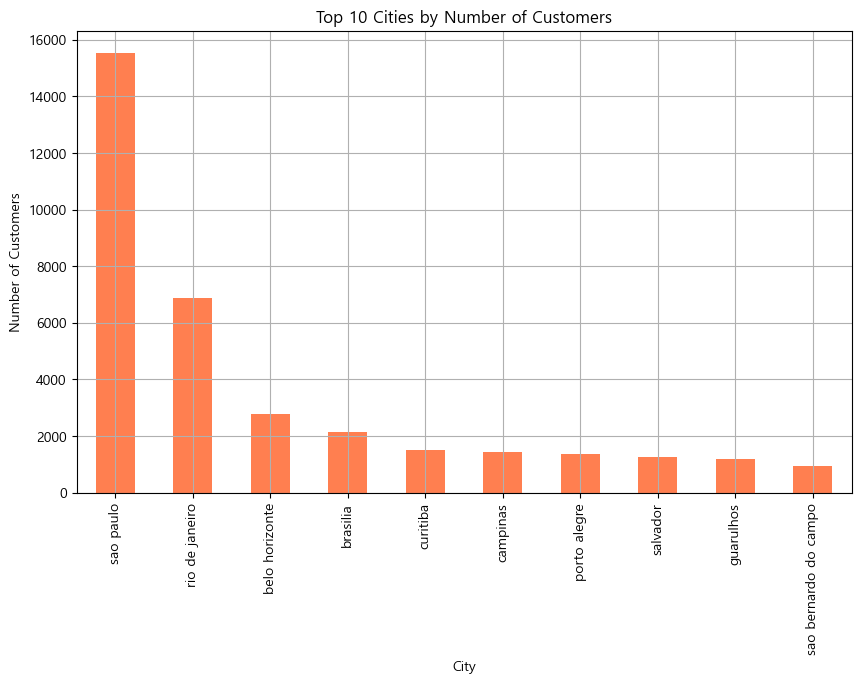

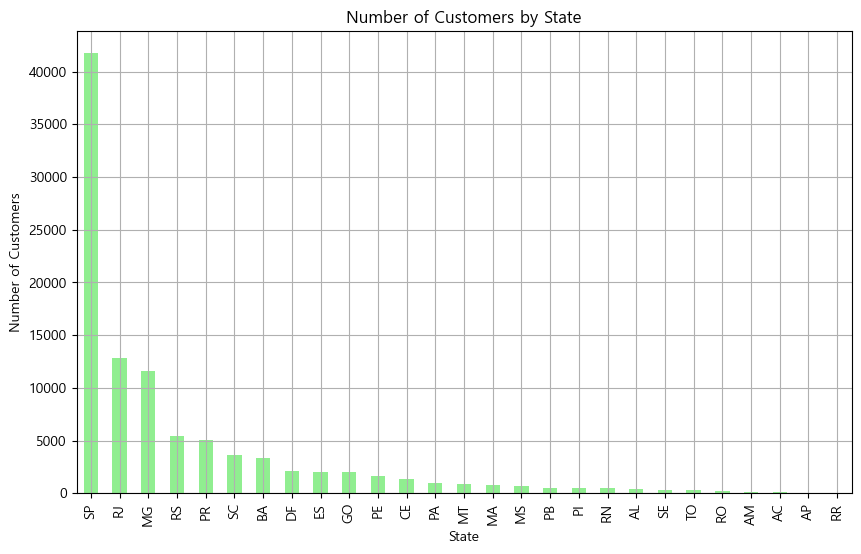

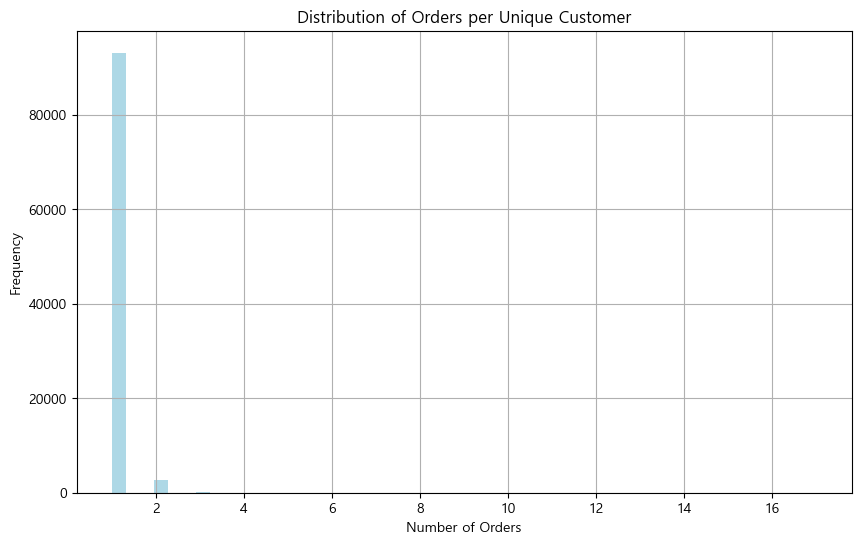

In [ ]:
import matplotlib.pyplot as plt

# 히스토그램: customer_zip_code_prefix 분포
plt.figure(figsize=(10, 6))
customers['customer_zip_code_prefix'].plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribution of Customer Zip Code Prefix')
plt.xlabel('Zip Code Prefix')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 막대그래프: 상위 10개 도시별 고객 수
top_10_cities = customers['customer_city'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_10_cities.plot(kind='bar', color='coral')
plt.title('Top 10 Cities by Number of Customers')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

# 막대그래프: 각 주별 고객 수
customer_states = customers['customer_state'].value_counts()
plt.figure(figsize=(10, 6))
customer_states.plot(kind='bar', color='lightgreen')
plt.title('Number of Customers by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

# 히스토그램: 고객별 주문 횟수 분포
plt.figure(figsize=(10, 6))
customer_order_counts.plot(kind='hist', bins=50, color='lightblue')
plt.title('Distribution of Orders per Unique Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

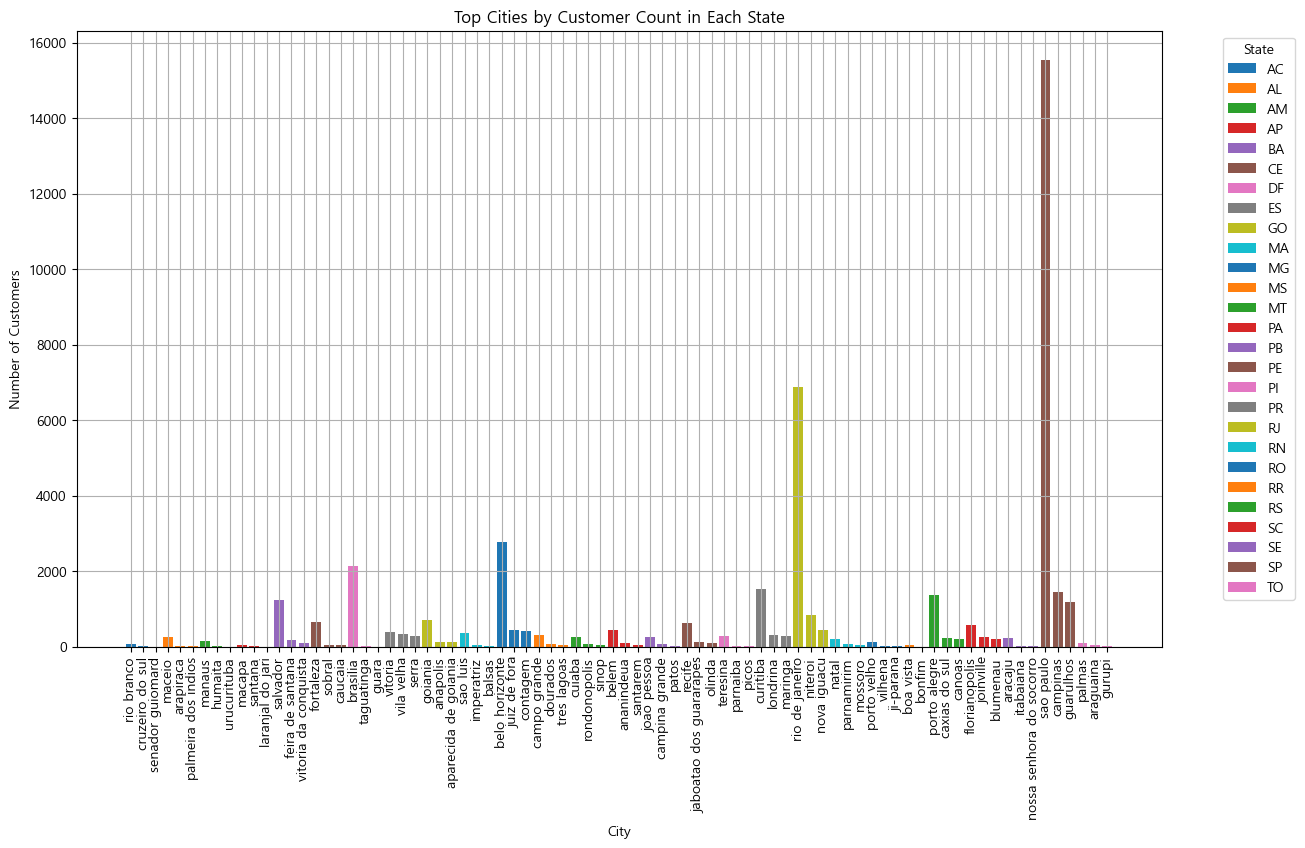

In [ ]:
# 주별 상위 도시에 대한 고객 수 확인
top_cities_per_state = customers.groupby(['customer_state', 'customer_city']).size().reset_index(name='customer_count')
top_cities_per_state = top_cities_per_state.sort_values(['customer_state', 'customer_count'], ascending=[True, False])
top_cities_per_state_per_state = top_cities_per_state.groupby('customer_state').head(3).reset_index(drop=True)

# 시각화: 주별 상위 도시별 고객 수
plt.figure(figsize=(14, 8))
for state in top_cities_per_state_per_state['customer_state'].unique():
    subset = top_cities_per_state_per_state[top_cities_per_state_per_state['customer_state'] == state]
    plt.bar(subset['customer_city'], subset['customer_count'], label=state)

plt.title('Top Cities by Customer Count in Each State')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

RPM 분석
- R(Recency, 얼마나 최근)
- F(Frequency, 얼마나 자주)
- M(Monetary, 얼마나 많이)

단계

1. 데이터 확인
2. 각 주문의 총 금액을 계산
3. 각 고객의 최근 구매 날짜(Recency), 구매 빈도(Frequency), 총 구매 금액(Monetary)을 계산
4. 각 지표를 5점 척도로 스코어링

1. 데이터 확인

In [ ]:
customers.head(), orders.head(), payments.head(), reviews.head()

(                        customer_id                customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
 1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
 2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
 3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
 4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
 
    customer_zip_code_prefix          customer_city customer_state  
 0                     14409                 franca             SP  
 1                      9790  sao bernardo do campo             SP  
 2                      1151              sao paulo             SP  
 3                      8775        mogi das cruzes             SP  
 4                     13056               campinas             SP  ,
                            order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10

2. 각 주문의 총 금액을 계산

In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
# 주문별 총 결제금액
order_payment_total = payments.groupby('order_id')['payment_value'].sum().reset_index()

# 합치기
orders_df = pd.merge(orders, order_payment_total, on='order_id')

# 데이터 확인
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62


3. 각 고객의 RFM 값 계산

In [ ]:
import pandas as pd
from datetime import datetime

# Merge orders with customers data to get customer_id for each order
orders_customers_df = pd.merge(orders_df, customers, on='customer_id')

# Get the current timestamp
now = datetime(2018, 12, 31)

# Calculate Recency, Frequency, Monetary for each customer
rfm_df = orders_customers_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (now - pd.to_datetime(x).max()).days, # Use the defined 'now'
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

# Rename columns for clarity
rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# Display the first few rows of the RFM dataframe
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,234,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,237,1,27.19
2,0000f46a3911fa3c0805444483337064,660,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,444,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,411,1,196.89


4. 각 지표를 5점 척도로 스코어링

In [11]:
# RPM
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm_df['RFM_score'] = rfm_df[['R_score', 'F_score', 'M_score']].sum(axis=1)

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,234,1,141.90,4,1,4,9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,237,1,27.19,4,1,1,6
2,0000f46a3911fa3c0805444483337064,660,1,86.22,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,444,1,43.62,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,411,1,196.89,2,1,4,7


### 세분화, 특징 및 전략

C:\Users\samsung\AppData\Local\Temp\ipykernel_10412\128898043.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('segment')


,segment,n_customers,recency_avg,freq_avg,monetary_avg,share(%)
0,Hibernating,27164,484.53,1.00,134.54,28.27
1,Potential Loyalists,16539,213.26,1.00,106.22,17.21
2,Need Attention,16119,344.87,1.04,177.07,16.77
3,At Risk,15934,440.95,1.04,191.64,16.58
4,Loyal,7609,214.57,1.02,189.02,7.92
5,Champions,6699,214.23,1.19,317.59,6.97
6,New Customers,3023,215.18,1.00,54.81,3.15
7,Can't Lose,3008,599.77,1.12,318.54,3.13


C:\Users\samsung\AppData\Local\Temp\ipykernel_10412\128898043.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['region','segment'])['customer_unique_id']


segment,Champions,Loyal,Potential Loyalists,New Customers,Need Attention,At Risk,Can't Lose,Hibernating
region,,,,,,,,
Central-West,7.60,8.00,15.90,2.70,18.00,17.60,3.10,27.20
North,8.60,7.40,11.30,1.80,16.40,18.80,4.50,31.20
Northeast,7.70,8.20,14.10,1.80,17.00,19.00,4.30,27.90
South,7.20,8.00,15.30,2.70,17.00,16.60,3.40,29.80
Southeast,6.70,7.90,18.30,3.50,16.60,16.10,2.90,28.00


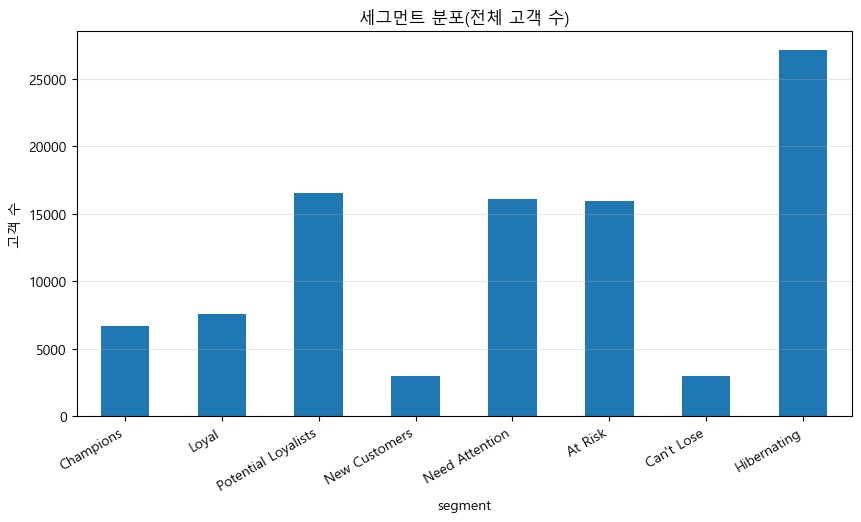

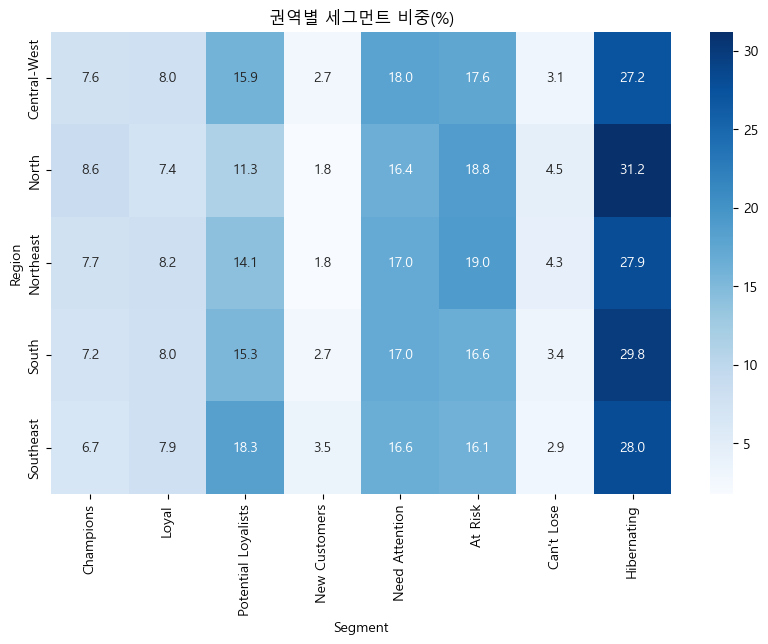

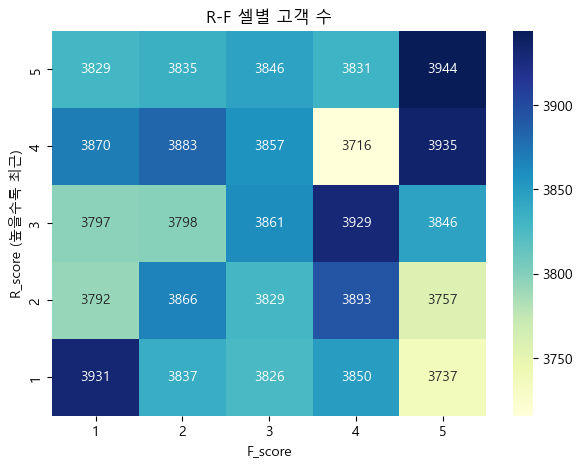

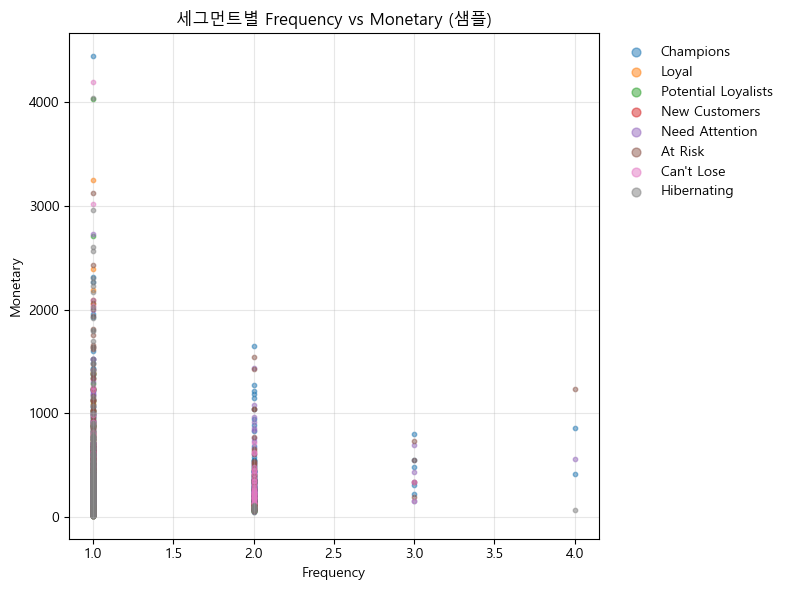

,특징,전략(요약)
segment,,
Champions,가장 최근·자주·고액 구매,"프리미엄 멤버십/얼리액세스/한정판 제공 / 고가 번들/업셀링, VIP 전담 CS /..."
Loyal,"구매 빈도 높고 금액도 상위권, 최근성도 양호",적립/구독(정기배송) 제안으로 LTV 증대 / 카테고리 크로스셀(연관 카테고리 쿠폰...
Potential Loyalists,최근 유입 후 반복 구매 시작,첫 3회 구매까지 누적 혜택 강화(스텝업 쿠폰) / 개인화 추천으로 구매 카테고리 ...
New Customers,최근 첫 구매/초기 구매 단계,온보딩 시퀀스(브랜드/반품/배송 안내) / 2차 구매 유도 쿠폰 & 베스트셀러 추천...
Need Attention,"활동 둔화 조짐(최근성 보통, F/M 중상)",관심 카테고리 가격알림/품절해제 알림 / 충성도 페이스메이커: 누적혜택 소멸 알림 ...
At Risk,과거 우수 고객이나 최근 구매 단절,재활성 캠페인(강한 인센티브/무료반품) / 개인화 복귀 시나리오(최근 본 상품·위시...
Can't Lose,매우 높은 F/M이지만 최근성 낮음(이탈 위험),"재참여 전용 한정 혜택(고가 번들, VIP 복귀쿠폰) / 담당자 접촉/전화 케어(고..."
Hibernating,저빈도·저객단가·오래됨,"대중 프로모션, SNS/퍼포먼스 광고 리타게팅 / 낮은 진입가 체험/샘플 번들 / ..."



[권역별 TOP 세그먼트 & 추천 전략 요약]


C:\Users\samsung\AppData\Local\Temp\ipykernel_10412\128898043.py:223: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['region','segment'])['customer_unique_id']



- Southeast
  · Hibernating: 저빈도·저객단가·오래됨
     - 대중 프로모션, SNS/퍼포먼스 광고 리타게팅
     - 낮은 진입가 체험/샘플 번들
  · Potential Loyalists: 최근 유입 후 반복 구매 시작
     - 첫 3회 구매까지 누적 혜택 강화(스텝업 쿠폰)
     - 개인화 추천으로 구매 카테고리 고착

- South
  · Hibernating: 저빈도·저객단가·오래됨
     - 대중 프로모션, SNS/퍼포먼스 광고 리타게팅
     - 낮은 진입가 체험/샘플 번들
  · Need Attention: 활동 둔화 조짐(최근성 보통, F/M 중상)
     - 관심 카테고리 가격알림/품절해제 알림
     - 충성도 페이스메이커: 누적혜택 소멸 알림

- Northeast
  · Hibernating: 저빈도·저객단가·오래됨
     - 대중 프로모션, SNS/퍼포먼스 광고 리타게팅
     - 낮은 진입가 체험/샘플 번들
  · At Risk: 과거 우수 고객이나 최근 구매 단절
     - 재활성 캠페인(강한 인센티브/무료반품)
     - 개인화 복귀 시나리오(최근 본 상품·위시리스트)

- Central-West
  · Hibernating: 저빈도·저객단가·오래됨
     - 대중 프로모션, SNS/퍼포먼스 광고 리타게팅
     - 낮은 진입가 체험/샘플 번들
  · Need Attention: 활동 둔화 조짐(최근성 보통, F/M 중상)
     - 관심 카테고리 가격알림/품절해제 알림
     - 충성도 페이스메이커: 누적혜택 소멸 알림

- North
  · Hibernating: 저빈도·저객단가·오래됨
     - 대중 프로모션, SNS/퍼포먼스 광고 리타게팅
     - 낮은 진입가 체험/샘플 번들
  · At Risk: 과거 우수 고객이나 최근 구매 단절
     - 재활성 캠페인(강한 인센티브/무료반품)
     - 개인화 복귀 시나리오(최근 본 상품·위시리스트)

[알림] sci

In [ ]:
pd.options.display.float_format = lambda x: f"{x:,.2f}"

# 1) 고객 지역(브라질 5대 권역) 매핑 -----------------------------------------
#   - Olist의 customers_df에는 'customer_state'(UF 코드)가 있습니다.
#   - 권역(Region) 기준으로 세분화할 수 있도록 매핑합니다.
uf_to_region = {
    # North
    "AC":"North","AP":"North","AM":"North","PA":"North","RO":"North","RR":"North","TO":"North",
    # Northeast
    "AL":"Northeast","BA":"Northeast","CE":"Northeast","MA":"Northeast","PB":"Northeast",
    "PE":"Northeast","PI":"Northeast","RN":"Northeast","SE":"Northeast",
    # Central-West
    "DF":"Central-West","GO":"Central-West","MT":"Central-West","MS":"Central-West",
    # Southeast
    "ES":"Southeast","MG":"Southeast","RJ":"Southeast","SP":"Southeast",
    # South
    "PR":"South","RS":"South","SC":"South"
}

# customer_unique_id 기준 대표 주/권역 추출(동일 unique_id 다수 행 있을 수 있어 mode 사용)
cust_state_mode = (
    customers
      .groupby('customer_unique_id')['customer_state']
      .agg(lambda s: s.value_counts().index[0])
      .to_frame()
      .reset_index()
)
cust_state_mode['region'] = cust_state_mode['customer_state'].map(uf_to_region)

rfm_geo = rfm_df.merge(cust_state_mode, on='customer_unique_id', how='left')

# 2) RFM 스코어 정수 변환 & 세그먼트 라벨링 -----------------------------------
for col in ['R_score','F_score','M_score']:
    if str(rfm_geo[col].dtype) == 'category':
        rfm_geo[col] = rfm_geo[col].astype(int)
    else:
        rfm_geo[col] = rfm_geo[col].astype(int)

# 대표 RFM 코드(예: 5-5-5)
rfm_geo['RFM_cell'] = (
    rfm_geo['R_score'].astype(str) + rfm_geo['F_score'].astype(str) + rfm_geo['M_score'].astype(str)
)

# 룰 기반 세그먼트(간결/실무형 룰셋)
def rfm_segment(row):
    R, F, M = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if R>=4 and F>=4 and M>=4: return 'Champions'
    if R>=4 and F>=3 and M>=3: return 'Loyal'
    if R>=4 and F>=2:          return 'Potential Loyalists'
    if R>=4 and F<=2 and M<=2: return 'New Customers'
    if R==3 and (F>=3 or M>=3):return 'Need Attention'
    if R==2 and (F>=3 or M>=3):return 'At Risk'
    if R<=2 and F>=4 and M>=4: return "Can't Lose"
    return 'Hibernating'

rfm_geo['segment'] = rfm_geo.apply(rfm_segment, axis=1)

# 세그먼트 순서(시각화 가독성)
seg_order = [
    'Champions','Loyal','Potential Loyalists','New Customers',
    'Need Attention','At Risk',"Can't Lose",'Hibernating'
]
rfm_geo['segment'] = pd.Categorical(rfm_geo['segment'], categories=seg_order, ordered=True)

# 3) 세그먼트 프로파일 요약표 ---------------------------------------------------
seg_profile = (
    rfm_geo
      .groupby('segment')
      .agg(
          n_customers = ('customer_unique_id','nunique'),
          recency_avg = ('Recency','mean'),
          freq_avg    = ('Frequency','mean'),
          monetary_avg= ('Monetary','mean')
      )
      .sort_values('n_customers', ascending=False)
      .reset_index()
)
seg_profile['share(%)'] = (seg_profile['n_customers'] / seg_profile['n_customers'].sum() * 100).round(2)
display(seg_profile)

# 4) 권역별 세그먼트 분포(비중) ------------------------------------------------
region_seg = (
    rfm_geo
      .dropna(subset=['region'])
      .groupby(['region','segment'])['customer_unique_id']
      .nunique()
      .reset_index(name='n')
)

region_tot = region_seg.groupby('region')['n'].sum().rename('region_total')
region_seg = region_seg.merge(region_tot, on='region')
region_seg['share'] = region_seg['n'] / region_seg['region_total']

pivot_region_seg = region_seg.pivot(index='region', columns='segment', values='share').fillna(0).reindex(columns=seg_order)
display((pivot_region_seg*100).round(1))

# 5) 시각화 -------------------------------------------------------------------
plt.figure(figsize=(10,5))
counts = rfm_geo['segment'].value_counts().reindex(seg_order)
counts.plot(kind='bar')
plt.title('세그먼트 분포(전체 고객 수)')
plt.ylabel('고객 수')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap((pivot_region_seg*100).round(1), annot=True, fmt=".1f", cmap='Blues')
plt.title('권역별 세그먼트 비중(%)')
plt.ylabel('Region'); plt.xlabel('Segment')
plt.show()

# R-F 그리드에서 고객수 히트맵(전형적인 RFM 셀 밀도)
rfm_rf = (
    rfm_geo
      .groupby(['R_score','F_score'])['customer_unique_id']
      .nunique()
      .reset_index(name='n')
      .pivot(index='R_score', columns='F_score', values='n')
      .sort_index(ascending=False)
)
plt.figure(figsize=(7,5))
sns.heatmap(rfm_rf, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('R-F 셀별 고객 수')
plt.xlabel('F_score'); plt.ylabel('R_score (높을수록 최근)')
plt.show()

# 산점도: Frequency vs Monetary (샘플) - 세그먼트 색
sample_plot = rfm_geo.sample(min(10000, len(rfm_geo)), random_state=42)  # 과도한 점 개수 방지
plt.figure(figsize=(8,6))
for s in seg_order:
    d = sample_plot[sample_plot['segment']==s]
    plt.scatter(d['Frequency'], d['Monetary'], s=10, alpha=0.5, label=s)
plt.title('세그먼트별 Frequency vs Monetary (샘플)')
plt.xlabel('Frequency'); plt.ylabel('Monetary')
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 6) 세그먼트별 특성과 비즈니스 전략(요약 테이블) ------------------------------
strategy = {
    'Champions': {
        '특징': '가장 최근·자주·고액 구매',
        '전략': [
            '프리미엄 멤버십/얼리액세스/한정판 제공',
            '고가 번들/업셀링, VIP 전담 CS',
            '리뷰·추천(UGC) 참여 유도, 리퍼럴 리워드'
        ]
    },
    'Loyal': {
        '특징': '구매 빈도 높고 금액도 상위권, 최근성도 양호',
        '전략': [
            '적립/구독(정기배송) 제안으로 LTV 증대',
            '카테고리 크로스셀(연관 카테고리 쿠폰)',
            '장바구니 리마인더·리오더(주기 기반)'
        ]
    },
    'Potential Loyalists': {
        '특징': '최근 유입 후 반복 구매 시작',
        '전략': [
            '첫 3회 구매까지 누적 혜택 강화(스텝업 쿠폰)',
            '개인화 추천으로 구매 카테고리 고착',
            '구독 유도 전 테스트 번들 제공'
        ]
    },
    'New Customers': {
        '특징': '최근 첫 구매/초기 구매 단계',
        '전략': [
            '온보딩 시퀀스(브랜드/반품/배송 안내)',
            '2차 구매 유도 쿠폰 & 베스트셀러 추천',
            '리뷰 요청으로 신뢰 형성'
        ]
    },
    'Need Attention': {
        '특징': '활동 둔화 조짐(최근성 보통, F/M 중상)',
        '전략': [
            '관심 카테고리 가격알림/품절해제 알림',
            '충성도 페이스메이커: 누적혜택 소멸 알림',
            '이탈 방지용 NPS 조사 & 미스매치 개선'
        ]
    },
    'At Risk': {
        '특징': '과거 우수 고객이나 최근 구매 단절',
        '전략': [
            '재활성 캠페인(강한 인센티브/무료반품)',
            '개인화 복귀 시나리오(최근 본 상품·위시리스트)',
            'CS 이슈 점검 및 원인 케어'
        ]
    },
    "Can't Lose": {
        '특징': '매우 높은 F/M이지만 최근성 낮음(이탈 위험)',
        '전략': [
            '재참여 전용 한정 혜택(고가 번들, VIP 복귀쿠폰)',
            '담당자 접촉/전화 케어(고객 규모에 따라)',
            '회복 이후 구독/정기배송으로 락인'
        ]
    },
    'Hibernating': {
        '특징': '저빈도·저객단가·오래됨',
        '전략': [
            '대중 프로모션, SNS/퍼포먼스 광고 리타게팅',
            '낮은 진입가 체험/샘플 번들',
            '반응 없는 경우 캠페인 빈도 최소화'
        ]
    }
}

strategies_df = (
    pd.DataFrame([
        {'segment': seg, '특징': v['특징'], '전략(요약)': ' / '.join(v['전략'])}
        for seg, v in strategy.items()
    ])
    .set_index('segment')
    .reindex(seg_order)
)
display(strategies_df)

# 권역별 탑 세그먼트와 전략 요약(빠른 의사결정용)
print("\n[권역별 TOP 세그먼트 & 추천 전략 요약]")
top_by_region = (
    rfm_geo.dropna(subset=['region'])
           .groupby(['region','segment'])['customer_unique_id']
           .nunique()
           .sort_values(ascending=False)
           .groupby(level=0)
           .head(2)  # 권역별 상위 2개 세그먼트
           .reset_index()
)
for region in top_by_region['region'].unique():
    sub = top_by_region[top_by_region['region']==region]
    print(f"\n- {region}")
    for _, row in sub.iterrows():
        seg = row['segment']
        print(f"  · {seg}: {strategy.get(seg,{}).get('특징','')}")
        for rec in strategy.get(seg,{}).get('전략',[])[:2]:
            print(f"     - {rec}")
